In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


## Loading pretrained MobileNetV3


In [2]:
import torch
import torchvision.models as models

# Load MobileNetV3-Large pretrained on ImageNet
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)

# Load MobileNetV3-Small pretrained on ImageNet
# mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)

/home/abood/Documents/sync/Education/ENSA/ENSA_M3/Advanced_topics/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abood/Documents/sync/Education/ENSA/ENSA_M3/Advanced_topics/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /home/abood/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100.0%


## Fine-Tuning MobileNetV3 

#### Replace the Final Classification Layer

In [4]:
import torch.nn as nn

# Identify the number of input features to the last layer
num_features = mobilenet_v3_large.classifier[3].in_features  # 1280 for MobileNet V3 Large

# Modify the final layer for a custom number of classes (e.g., 1 for binary classification)
mobilenet_v3_large.classifier[3] = nn.Linear(in_features=num_features, out_features=1)

#### Set Up the DataLoaders

In [7]:
from torch.utils.data import DataLoader
from dataset import AntiSpoofDataset, get_transforms

# Define dataset roots
lcc_fasd_root = 'data/LCC_FASD'
siw_root = 'data/SiW'

# Load Training Dataset
train_dataset = AntiSpoofDataset(
    lcc_fasd_root=lcc_fasd_root,
    siw_root=siw_root,
    split='train',
    transform=get_transforms(split='train')
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load Validation Dataset
val_dataset = AntiSpoofDataset(
    lcc_fasd_root=lcc_fasd_root,
    siw_root=siw_root,
    split='val',
    transform=get_transforms(split='val')
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

/home/abood/Documents/sync/Education/ENSA/ENSA_M3/Advanced_topics/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


#### Train the Model

In [10]:
import torch.optim as optim
from tqdm import tqdm
import copy

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
mobilenet_v3_large = mobilenet_v3_large.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(mobilenet_v3_large.parameters(), lr=0.001)

# Training loop
num_epochs = 10
best_acc = 0.0
best_model_wts = copy.deepcopy(mobilenet_v3_large.state_dict())

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            mobilenet_v3_large.train()  # Set model to training mode
            dataloader = train_loader
        else:
            mobilenet_v3_large.eval()   # Set model to evaluate mode
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        # TQDM for progress tracking
        pbar = tqdm(dataloader, desc=f"{phase} phase", leave=False)

        for inputs, labels in pbar:
            inputs = inputs.to(device)
            # BCEWithLogitsLoss needs float target with shape [batch, 1]
            labels = labels.to(device).float().unsqueeze(1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = mobilenet_v3_large(inputs)
                loss = criterion(outputs, labels)

                # Convert logits to predictions (Sigmoid > 0.5 is typically threshold 0.0 in Logits)
                preds = (torch.sigmoid(outputs) > 0.5).float()

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            
            # Update pbar
            pbar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model if it's the best one so far
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(mobilenet_v3_large.state_dict())
            torch.save(mobilenet_v3_large.state_dict(), 'best_mobilenetv3_antispoof.pth')
            print("Model Saved!")

    print()

print(f'Best val Acc: {best_acc:4f}')

Using device: cuda
Epoch 1/10
----------


train phase:   0%|          | 0/450 [00:00<?, ?it/s]

train Loss: 0.0812 Acc: 0.9686


val Loss: 0.2094 Acc: 0.9562
Model Saved!

Epoch 2/10
----------


train Loss: 0.0355 Acc: 0.9873


val Loss: 0.1317 Acc: 0.9703
Model Saved!

Epoch 3/10
----------


train Loss: 0.0287 Acc: 0.9903


val Loss: 0.1852 Acc: 0.9613

Epoch 4/10
----------


train Loss: 0.0269 Acc: 0.9908


val Loss: 0.3110 Acc: 0.9043

Epoch 5/10
----------


train Loss: 0.0188 Acc: 0.9937


val Loss: 0.2279 Acc: 0.9154

Epoch 6/10
----------


train Loss: 0.0219 Acc: 0.9921


val Loss: 0.2487 Acc: 0.9500

Epoch 7/10
----------


train Loss: 0.0113 Acc: 0.9962


val Loss: 0.1673 Acc: 0.9562

Epoch 8/10
----------


train Loss: 0.0207 Acc: 0.9932


val Loss: 0.3237 Acc: 0.9256

Epoch 9/10
----------


train Loss: 0.0196 Acc: 0.9935


val Loss: 0.1213 Acc: 0.9651

Epoch 10/10
----------


train Loss: 0.0114 Acc: 0.9961


val Loss: 0.1222 Acc: 0.9700

Best val Acc: 0.970254


In [11]:
torch.save(mobilenet_v3_large.state_dict(), 'last_mobilenetv3_antispoof.pth')

In [ ]:
# Load best model weights
mobilenet_v3_large.load_state_dict(best_model_wts)

## Evaluating the Model

In [18]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# 1. Create the Test Loader
# We use the same 'get_transforms' but with split='val' or 'test' (usually no augmentation for test)
test_dataset = AntiSpoofDataset(
    lcc_fasd_root=lcc_fasd_root,
    siw_root=siw_root,
    split='test',
    transform=get_transforms(split='val') # Use 'val' transform (resize/normalize only)
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
# 2. Load the Best Saved Model
# Initialize the model structure again (if in a new session)
model = models.mobilenet_v3_large(pretrained=False) # Pretrained doesn't matter, we are loading weights
num_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_features, 1)

# Load the weights you saved during training
model.load_state_dict(torch.load('best_mobilenetv3_antispoof.pth'))
model = model.to(device)
model.eval()

/home/abood/Documents/sync/Education/ENSA/ENSA_M3/Advanced_topics/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abood/Documents/sync/Education/ENSA/ENSA_M3/Advanced_topics/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Starting testing...


Testing: 100%|██████████| 261/261 [01:03<00:00,  4.12it/s]



Classification Report:
              precision    recall  f1-score   support

    Real (0)       0.98      0.88      0.93       914
   Spoof (1)       0.99      1.00      0.99      7416

    accuracy                           0.99      8330
   macro avg       0.98      0.94      0.96      8330
weighted avg       0.99      0.99      0.99      8330



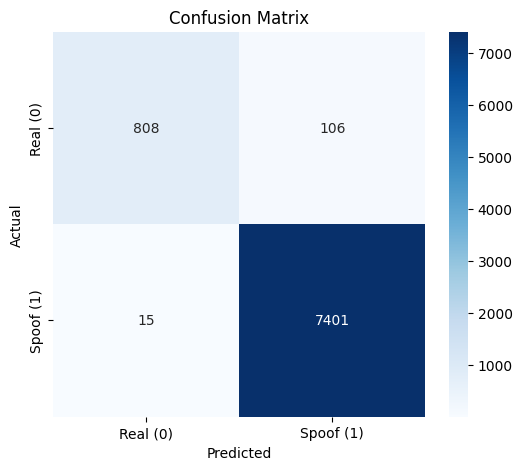

In [19]:
# 3. Run Inference
y_true = []
y_pred = []
y_probs = []

print("Starting testing...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get probabilities (sigmoid) and predictions (0 or 1)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        
        # Store results for metrics
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# Flatten arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# 4. Print Report
print("\nClassification Report:")
target_names = ['Real (0)', 'Spoof (1)']
print(classification_report(y_true, y_pred, target_names=target_names))

# 5. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()